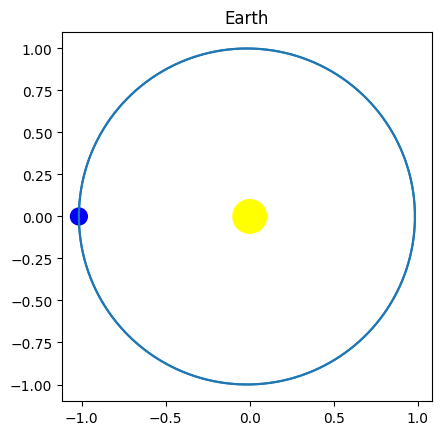

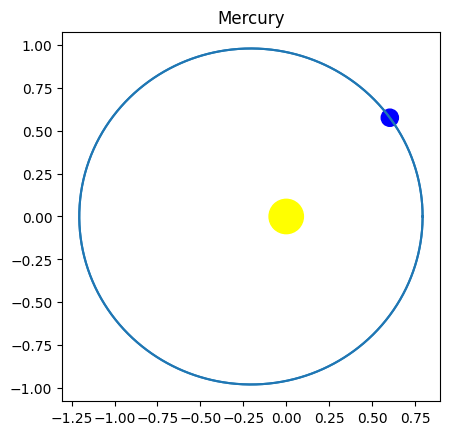

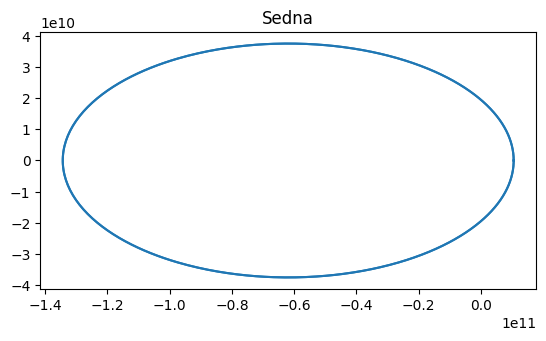

In [ ]:
import os


import math
import matplotlib.pyplot as plt
import numpy as np


def normalize_semi_major_axis(major_axis, minor_axis):
    semi_major_axis = major_axis / 2
    normalized_semi_major_axis = semi_major_axis / (semi_major_axis + minor_axis / 2)
    return normalized_semi_major_axis


def orbital_position(time, eccentricity, semi_major_axis, period):
    # Note: Not accurate. Just interpolates the ellipse. Does not take into account velocity.
    # Import math module for pi constant
    import math
    # Calculate the true anomaly using the approximation
    true_anomaly = 2 * math.pi * time / period
    # Convert the true anomaly to a fractional position in 0..1 range
    fractional_position = true_anomaly / (2 * math.pi)
    # Return the fractional position as output
    return fractional_position


def draw_orbit(planet_name, eccentricity, semi_major_axis, period, fig=None, ax=None):
    semi_minor_axis = semi_major_axis * np.sqrt(1 - eccentricity ** 2)

    # Define the sun as a yellow circle
    sun = plt.Circle((0, 0), 0.1, color='yellow')

    # Define the planet as a blue circle
    planet = plt.Circle((semi_major_axis * (1 - eccentricity), 0), 0.05, color='blue')

    # Define the orbit as an ellipse around the sun
    theta = np.linspace(0, 2 * np.pi, 1000)
    r = semi_major_axis * (1 - eccentricity ** 2) / (1 + eccentricity * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    orbit = ax.plot(x, y)

    # Position the planet on the orbit ellipse at the fractional value
    #fractional_value = orbital_position(period, eccentricity, semi_major_axis, 1.0)
    fractional_value = period
    planet_x = semi_major_axis * (np.cos(2 * np.pi * fractional_value) - eccentricity)
    planet_y = semi_minor_axis * np.sin(2 * np.pi * fractional_value)
    planet.center = (planet_x, planet_y)

    # Plot everything
    if fig is None and ax is None:
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.add_artist(sun)
        ax.add_artist(planet)
        ax.add_artist(orbit[0])
        plt.show()
    else:
        ax.set_aspect('equal')
        ax.add_artist(sun)
        ax.add_artist(planet)
        ax.add_artist(orbit[0])

    ax.set(title=planet_name)


# Earth
fig, ax = plt.subplots()
draw_orbit("Earth", 0.0167, 1, 0.5, fig=fig, ax=ax)
plt.show()

# Mercury
fig, ax = plt.subplots()
draw_orbit("Mercury", 0.2056, 1, 0.1, fig=fig, ax=ax)
plt.show()

# Sedna
fig, ax = plt.subplots()
draw_orbit("Sedna", 0.855, 7.24e10, 0.1, fig=fig, ax=ax)
plt.show()


In [12]:
import celestial_sandbox.orbital_elements.eccentricity
import celestial_sandbox.orbital_elements.semi_major_axis


class OrbitalProperties(object):
    def __init__(self, shape, semi_major_axis, pitch_period, yaw_period, roll_period, phase):
        """
        :param <float:shape> Eccentricity of the orbit, where 0.0 is a perfect circle, and 1.0 is an ellipse
        :param <int:semi_major_axis> The semi-major axis, half of the distance of the largest diamiter of the ellipse (in kilometers)
        :param <float:pitch_period> Inclination [0..1], the vertical tilt of the ellipse with respect to the reference pane
        :param <float:yaw_period> Longitude of the ascending node [0..1], horizontal orientation of the ellipse relative to the up vector of the sun
        :param <float:roll_period> Argument of Periapsis [0..1], orientation of the ellipse in the orbital plane (the side to side rotation)
        :param <float:phase> Fraction of a full orbit that the body has completed (where 0.0 = 0 rotations, 0.5 = half a rotation, and 1.0 = one rotation)
        """
        self.shape = shape
        self.semi_major_axis = semi_major_axis
        self.pitch = pitch_period * 2 * math.pi
        self.yaw = yaw_period * 2 * math.pi
        self.roll = roll_period * 2 * math.pi

        self.phase = phase

    @property
    def true_anomaly(self):
        """
        The angle between the body and the sun as seen from the center of the ellipse
        :return <float:true_anomaly> The true anomaly in radians
        """
        # The true anomaly is equal to the phase parameter in radians
        return self.phase * 2.0 * math.pi

    @property
    def periapsis(self):
        """
        :return <int:periapsis> The periapsis distance, minimum distance from the planet to the star (in Kilometers)
        """
        return celestial_sandbox.orbital_elements.semi_major_axis.periapsis_from_semi_major_axis(self.semi_major_axis, self.shape)
    
    @property
    def apoapsis(self):
        """
        :return <int:apoapsis> The apoapsis distance, the maximum distance from the planet to the star (in Kilometers)
        """
        return celestial_sandbox.orbital_elements.semi_major_axis.apoapsis_from_semi_major_axis(self.semi_major_axis, self.shape)
    
    @property
    def period(self):
        """
        :return <float:period> The orbital period, how long it takes for a full revolution around the star (in Years)
        """
        # NOTE? Do we want to include this? Mass is not being included, it should be a manual property.
        mass_ratio = 1.0
        semi_major_axis_au = self.semi_major_axis / 149597870.7
        period_seconds = math.sqrt((semi_major_axis_au ** 3) / mass_ratio )
        period_years = period_seconds / 31557600
        return period_years
    
    @property
    def eccentric_anomaly(self):
        """
        The angle between the center of the orbit and the point where the body would be if it moved in a circle instead of an ellipse
        :return <float:eccentric_anomaly> The eccentric anomaly in radians
        """
        return celestial_sandbox.orbital_elements.eccentricity.eccentric_anomaly(self.shape, self.true_anomaly)
    
    @property
    def mean_anomaly(self):
        """
        The angle that a body moving in a circle with constant speed would have covered in the same time as the actual body in its elliptical orbit
        In simple terms, this is the angle that a fake body would have if it moved in a perfect circle, with the same time as the real body, at a steady speed.
        :return <float:mean_anomaly> The mean anomaly in radians
        """
        return celestial_sandbox.orbital_elements.eccentricity.mean_anomaly(self.shape, self.eccentric_anomaly)
    

example_orbit = OrbitalProperties(
    0.01671,  # eccentricity
    149_597_887.5,  # semimajor axis
    0.001,  # pitch
    0.196,  # yaw
    4.935 / (2.0 * math.pi),  # roll
    0.125,  # phase
)

print("The periapsis distance is:", example_orbit.periapsis, "kilometers")
print("The apoapsis distance is:", example_orbit.apoapsis, "kilometers")
print("The orbital period is:", example_orbit.period, "years")
print("The eccentric anomaly is:", example_orbit.eccentric_anomaly, "radians")
# print("The mean anomaly is:", example_orbit.mean_anomaly, "radians")



The periapsis distance is: 147098106.799875 kilometers
The apoapsis distance is: 152097668.200125 kilometers
The orbital period is: 3.1688093151938056e-08 years
The eccentric anomaly is: 0.7736511249471406 radians


# More Info

[Eccentric Anomaly](https://en.wikipedia.org/wiki/Eccentric_anomaly)

(From Wikipedia)

In orbital mechanics, the eccentric anomaly is an angular parameter that defines the position of a body that is moving along an elliptic Kepler orbit. The eccentric anomaly is one of three angular parameters ("anomalies") that define a position along an orbit, the other two being the true anomaly and the mean anomaly.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/48/EccentricAnomaly.svg"  width="500">

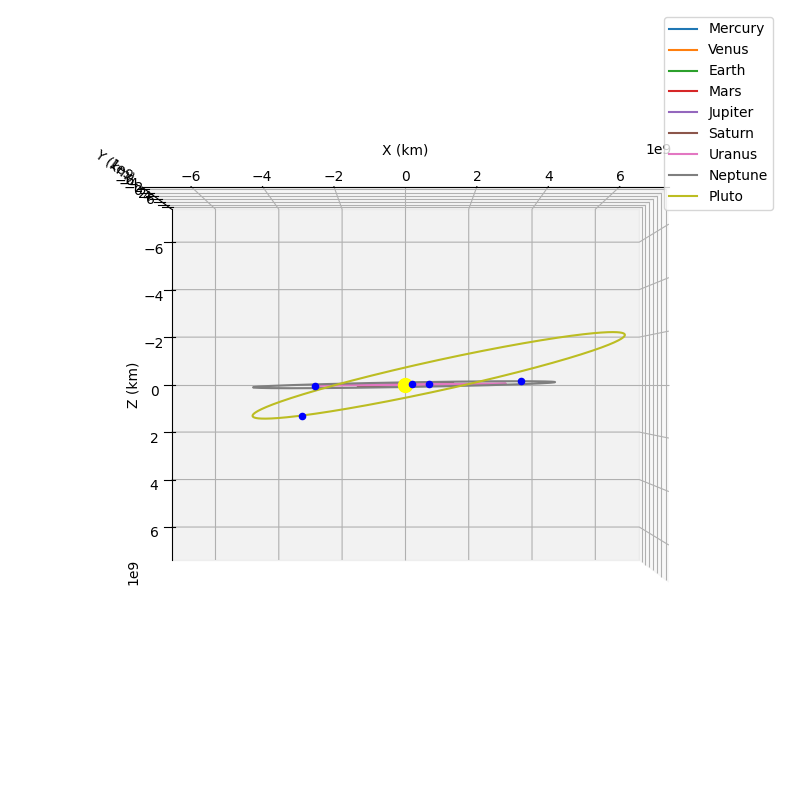

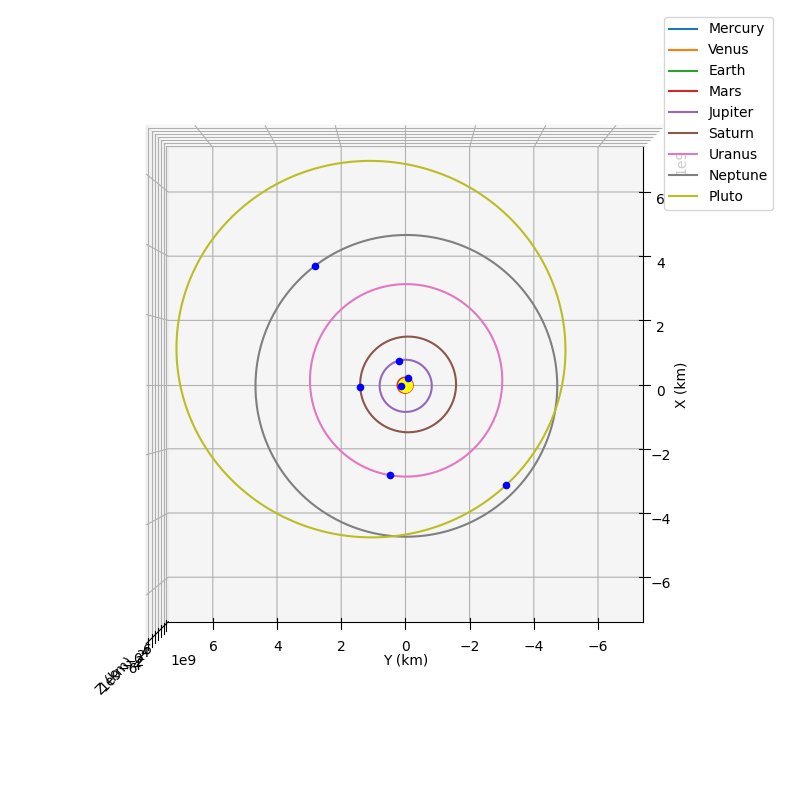

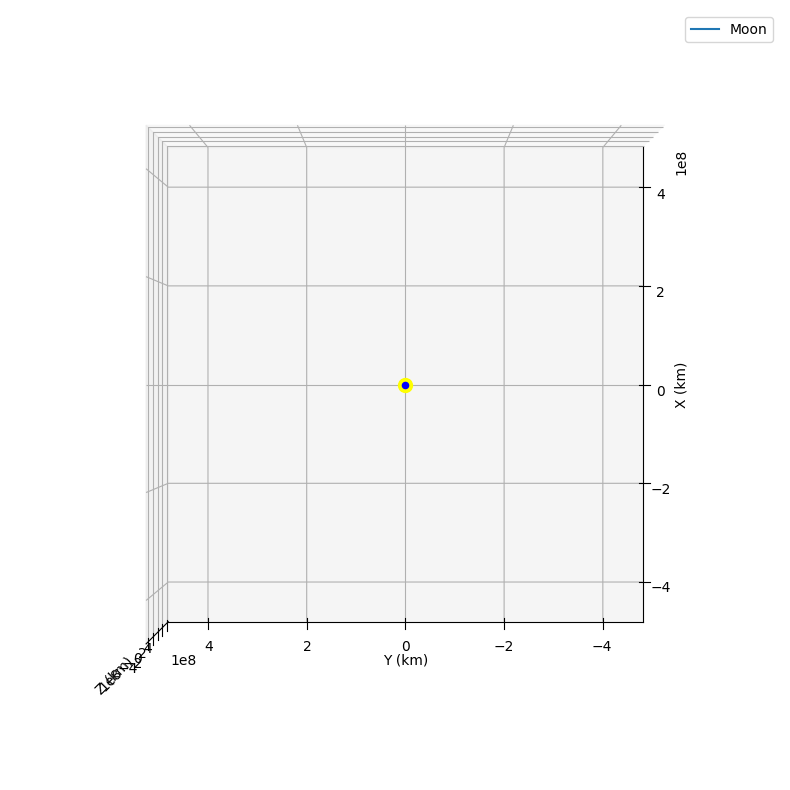

In [13]:
import celestial_sandbox.orbit


import numpy as np
import matplotlib.pyplot as plt

import celestial_sandbox.types.orbit
import celestial_sandbox.orbit


def plot_orbit(orbital_elements, show_star=True, orbit_equalization=True, view=[0.0, 0.0, 1.0]):
    """
    Plots the orbit of a celestial body given its orbital elements.
    :param <list:orbital_elements> A list of arrays containing the semi-major axis (in kilometers), eccentricity,
    :param [<bool:orbit_equalization>] If True then orbits are spaced evenly (for viewing simply)
    inclination (in radians), longitude of the ascending node (in radians), and argument of periapsis (in radians).
    """
    # Generate an array of true anomalies
    nu = np.linspace(0, 2 * np.pi, 100)

    # Plot the orbit
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    max_ = 0
    for i in orbital_elements:
        if(i.semi_major_axis > max_):
            max_ = i.semi_major_axis
    max_ *=- 1.25
    ax.set_xlim([-max_, max_])
    ax.set_ylim([-max_, max_])
    ax.set_zlim([-max_, max_])

    # if orbit equalization is enabled - then each orbit is at an equal distance from the last
    positions = []
    if(orbit_equalization):
        pass
    else:
        pass

    # Plot the sun at the center
    if(show_star):
        ax.scatter([0], [0], [0], color='yellow', s=100)
    
    for ii in range(len(orbital_elements)):
        orbit = orbital_elements[ii]
        orbital_period = orbit.orbital_period
        equalized_semi_major_axis = (ii + 1) / float(len(orbital_elements))
        
        r = np.array([orbit.position_vector(
            orbital_period * (i / 1000.0),
            semi_major_axis=equalized_semi_major_axis if orbit_equalization else None
        ) for i in range(1000)])

        name = orbit.name or f"Orbit {ii + 1}"
        ax.plot(r[:, 0], r[:, 1], r[:, 2], label=name)

        num_intervals = 1
        num_days = 360
        for i in range(num_intervals):
            day = num_days * (i / float(num_intervals))
            p = orbit.position_vector(day, semi_major_axis=equalized_semi_major_axis if orbit_equalization else None)
            ax.scatter(p[0], p[1], p[2], color="blue")

    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')

    up_vector = [0.0, 0.0, 1.0]
    ax.view_init(elev=90 - np.degrees(np.arccos(view[2])), azim=np.degrees(np.arctan2(view[1], view[0])))

    ax.legend()

    plt.show()



mercury = celestial_sandbox.types.orbit.Orbit(57900000, 0.2056, np.radians(7.0), np.radians(48.3), np.radians(77.5), name="Mercury", orbital_period=88)
venus = celestial_sandbox.types.orbit.Orbit(108200000, 0.0068, np.radians(3.39), np.radians(76.7), np.radians(54.9), name="Venus", orbital_period=225)
earth = celestial_sandbox.types.orbit.Orbit(149600000, 0.0167, np.radians(0), np.radians(174.9), np.radians(288.1), name="Earth", orbital_period=365)
mars = celestial_sandbox.types.orbit.Orbit(227900000, 0.0934, np.radians(1.85), np.radians(49.6), np.radians(286.5), name="Mars", orbital_period=687)
jupiter = celestial_sandbox.types.orbit.Orbit(778300000, 0.0489, np.radians(1.31), np.radians(100.5), np.radians(273.8), name="Jupiter", orbital_period=4333)
saturn = celestial_sandbox.types.orbit.Orbit(1430000000, 0.0565, np.radians(2.49), np.radians(113.7), np.radians(339.4), name="Saturn", orbital_period=10759)
uranus = celestial_sandbox.types.orbit.Orbit(2870000000, 0.0444, np.radians(0.77), np.radians(74.0), np.radians(96.5), name="Uranus", orbital_period=30687)
neptune = celestial_sandbox.types.orbit.Orbit(4500000000, 0.0113, np.radians(1.77), np.radians(131.8), np.radians(265.6), name="Neptune", orbital_period=60190)

pluto = celestial_sandbox.types.orbit.Orbit(5.91e9, 0.2488, np.radians(17.2), np.radians(110.3), np.radians(113.8), name="Pluto", orbital_period=90_520)
sedna = celestial_sandbox.types.orbit.Orbit(519.6e6, 0.855, np.radians(11.9), np.radians(144.3), np.radians(311.8), name="Sedna", orbital_period=4_158_600)

moon = celestial_sandbox.types.orbit.Orbit(384400000, 0.0549, np.radians(5.145), np.radians(0), np.radians(0), name="Moon", orbital_period=27.3217)

#planets = [mercury, venus, earth, mars]
planets = [mercury, venus, earth, mars, jupiter, saturn, uranus, neptune, pluto]
#planets = [earth]

for planet in planets:
    #planet.eccentricity = 0.25
    #planet.longitude_of_ascending_node = 0.0
    #planet.argument_of_periapsis = 0.0
    #planet.eccentricity = 0.0
    pass

plot_orbit(planets, orbit_equalization=False, view=[0.0, 1.0, 0.0])
plot_orbit(planets, orbit_equalization=False, view=[0.0, 0.0, 1.0])


plot_orbit([moon], orbit_equalization=True)

